# Лабораторная работа 3. Описательная статистика

**Датасет:** GTZAN Genre Collection — 1000 аудиозаписей (30 сек), 10 музыкальных жанров (по 100 записей), 57 числовых аудиопризнаков.

**Цели работы:**
1. Провести описательный статистический анализ каждого признака (центральные метрики, вариативность, форма распределения)
2. Рассчитать матрицу корреляции числовых признаков
3. Выявить взаимосвязь между входными признаками и целевой переменной (жанр)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

sns.set_style("whitegrid")
pd.set_option("display.max_columns", 30)
pd.set_option("display.float_format", lambda x: f"{x:.4f}")

## Загрузка и первичный осмотр данных

In [2]:
data = pd.read_csv("../datasets/gtzan/features_30_sec.csv")

print(f"Размер датасета: {data.shape[0]} строк, {data.shape[1]} столбцов")
print(f"\nТипы данных:")
print(data.dtypes.value_counts())
print(f"\nПропущенные значения: {data.isnull().sum().sum()}")
data.head()

Размер датасета: 1000 строк, 60 столбцов

Типы данных:
float64    57
str         2
int64       1
Name: count, dtype: int64

Пропущенные значения: 0


,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,rolloff_mean,rolloff_var,zero_crossing_rate_mean,zero_crossing_rate_var,harmony_mean,...,mfcc14_mean,mfcc14_var,mfcc15_mean,mfcc15_var,mfcc16_mean,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.wav,661794,0.3501,0.0888,0.1302,0.0028,1784.1658,129774.0645,2002.4491,85882.7613,3805.8396,901505.4255,0.0830,0.0008,-0.0000,...,5.7480,40.5545,-5.1629,49.7754,0.7527,52.4209,-1.6902,36.5241,-0.4090,41.5971,-2.3035,55.0629,1.2213,46.9360,blues
1,blues.00001.wav,661794,0.3409,0.0950,0.0959,0.0024,1530.1767,375850.0736,2039.0365,213843.7555,3550.5221,2977893.3881,0.0560,0.0014,0.0001,...,4.2201,73.1525,-6.0121,52.4221,0.9280,55.3564,-0.7311,60.3145,0.2951,48.1206,-0.2835,51.1062,0.5312,45.7863,blues
2,blues.00002.wav,661794,0.3636,0.0853,0.1756,0.0027,1552.8119,156467.6434,1747.7023,76254.1923,3042.2602,784034.4607,0.0763,0.0010,0.0000,...,-1.0770,57.7111,-9.2293,36.5810,2.4517,40.5988,-7.7291,47.6394,-1.8164,52.3821,-3.4397,46.6397,-2.2313,30.5730,blues
3,blues.00003.wav,661794,0.4048,0.0940,0.1411,0.0063,1070.1066,184355.9424,1596.4129,166441.4948,2184.7458,1493194.3603,0.0333,0.0004,0.0000,...,-1.0793,62.2899,-2.8708,51.6516,0.7809,44.4278,-3.3196,50.2067,0.6370,37.3191,-0.6191,37.2597,-3.4074,31.9493,blues
4,blues.00004.wav,661794,0.3085,0.0878,0.0915,0.0023,1835.0043,343399.9393,1748.1721,88445.2090,3579.7576,1572977.8319,0.1015,0.0020,-0.0000,...,-7.5527,70.9433,-9.1647,75.7934,-4.5206,86.0992,-5.4540,75.2697,-0.9169,53.6139,-4.4048,62.9108,-11.7032,55.1952,blues


## Группы признаков

Датасет содержит 57 числовых аудиопризнаков, извлечённых из 30-секундных фрагментов музыки. Разделим их на логические группы:

- **Chroma** (2): тональные характеристики (`chroma_stft_mean`, `chroma_stft_var`)
- **Энергия / RMS** (2): громкость сигнала (`rms_mean`, `rms_var`)
- **Спектральные** (8): частотные характеристики — `spectral_centroid`, `spectral_bandwidth`, `rolloff`, `zero_crossing_rate` (mean + var)
- **Гармонические / перкуссивные** (4): `harmony_mean/var`, `perceptr_mean/var`
- **Темп** (1): `tempo`
- **MFCC** (40): мел-частотные кепстральные коэффициенты 1–20 (mean + var)

Каждый признак (кроме `tempo`) представлен парой: среднее (`_mean`) и дисперсия (`_var`) по кадрам аудиозаписи. Целевая переменная `label` — жанр (10 классов, по 100 записей).

In [3]:
numeric_cols = data.select_dtypes(include=[np.number]).columns.drop("length")
feature_cols = numeric_cols

feature_groups = {
    "Chroma": [c for c in feature_cols if "chroma" in c],
    "Энергия (RMS)": [c for c in feature_cols if "rms" in c],
    "Спектральные": [
        c for c in feature_cols
        if any(s in c for s in ["spectral_centroid", "spectral_bandwidth", "rolloff", "zero_crossing_rate"])
    ],
    "Гармонические": [c for c in feature_cols if any(s in c for s in ["harmony", "perceptr"])],
    "Темп": ["tempo"],
    "MFCC": [c for c in feature_cols if "mfcc" in c],
}

for name, cols in feature_groups.items():
    print(f"{name}: {len(cols)} признаков")
print(f"\nВсего числовых признаков: {len(feature_cols)}")
print(f"\nБаланс классов:")
print(data["label"].value_counts())

Chroma: 2 признаков
Энергия (RMS): 2 признаков
Спектральные: 8 признаков
Гармонические: 4 признаков
Темп: 1 признаков
MFCC: 40 признаков

Всего числовых признаков: 57

Баланс классов:
label
blues        100
classical    100
country      100
disco        100
hiphop       100
jazz         100
metal        100
pop          100
reggae       100
rock         100
Name: count, dtype: int64


## Центральные метрики и метрики вариативности

Для каждого числового признака рассчитаем:
- **Центральная тенденция:** среднее (mean), медиана (median), мода (mode), минимум, максимум
- **Вариативность:** дисперсия (variance), стандартное отклонение (std), квартили (Q1, Q2, Q3), межквартильный размах (IQR), размах (range)
- **Форма распределения:** асимметрия (skewness), эксцесс (kurtosis)

In [4]:
desc = data[feature_cols].describe().T
desc["median"] = data[feature_cols].median()
desc["mode"] = data[feature_cols].mode().iloc[0]
desc["variance"] = data[feature_cols].var()
desc["range"] = desc["max"] - desc["min"]
desc["IQR"] = desc["75%"] - desc["25%"]
desc["skewness"] = data[feature_cols].skew()
desc["kurtosis"] = data[feature_cols].kurtosis()

summary_cols = [
    "count", "mean", "median", "mode", "std", "variance",
    "min", "25%", "50%", "75%", "max", "range", "IQR",
    "skewness", "kurtosis",
]
desc[summary_cols].round(4)

,count,mean,median,mode,std,variance,min,25%,50%,75%,max,range,IQR,skewness,kurtosis
chroma_stft_mean,1000.0000,0.3787,0.3831,0.3903,0.0817,0.0067,0.1719,0.3196,0.3831,0.4359,0.6637,0.4917,0.1164,-0.0378,-0.3278
chroma_stft_var,1000.0000,0.0863,0.0866,0.0733,0.0077,0.0001,0.0446,0.0823,0.0866,0.0913,0.1081,0.0636,0.0090,-0.8553,2.6576
rms_mean,1000.0000,0.1309,0.1224,0.0881,0.0657,0.0043,0.0053,0.0867,0.1224,0.1757,0.3980,0.3927,0.0890,0.4427,-0.1235
rms_var,1000.0000,0.0031,0.0018,0.0004,0.0036,0.0000,0.0000,0.0009,0.0018,0.0036,0.0277,0.0277,0.0026,2.7488,9.5335
spectral_centroid_mean,1000.0000,2201.7809,2209.2631,2269.1280,715.9606,512599.5804,570.0404,1627.6973,2209.2631,2691.2947,4435.2439,3865.2035,1063.5974,0.2345,-0.4247
spectral_centroid_var,1000.0000,469691.5749,338486.1527,123908.5225,400899.5175,160720423105.9712,7911.2514,184350.5302,338486.1527,612147.9348,3036843.0616,3028931.8102,427797.4046,1.8350,4.6803
spectral_bandwidth_mean,1000.0000,2242.5411,2221.3928,1928.9535,526.3165,277009.0300,898.0662,1907.2406,2221.3928,2578.4698,3509.6464,2611.5802,671.2292,0.1030,-0.4310
spectral_bandwidth_var,1000.0000,137079.1552,111977.5480,43563.3708,96455.6663,9303695566.4278,10787.1851,67376.5544,111977.5480,182371.5768,694784.8115,683997.6265,114995.0224,1.7350,4.5498
rolloff_mean,1000.0000,4571.5493,4658.5245,4186.4594,1574.7916,2479968.5891,749.1406,3380.0696,4658.5245,5533.8105,8677.6727,7928.5321,2153.7408,0.1170,-0.4548
rolloff_var,1000.0000,1844345.0426,1476114.8724,642185.2451,1425084.5879,2030866082638.1816,14686.1186,772731.2308,1476114.8724,2555261.8029,8660900.4844,8646214.3658,1782530.5721,1.4530,2.4322


## Анализ асимметрии и эксцесса

Интерпретация:
- **Асимметрия (skewness):** |skew| < 0.5 — приблизительно симметричное распределение; 0.5–1.0 — умеренная асимметрия; > 1.0 — сильная асимметрия
- **Эксцесс (kurtosis):** > 0 — островершинное (тяжёлые хвосты); < 0 — плосковершинное; ≈ 0 — близко к нормальному

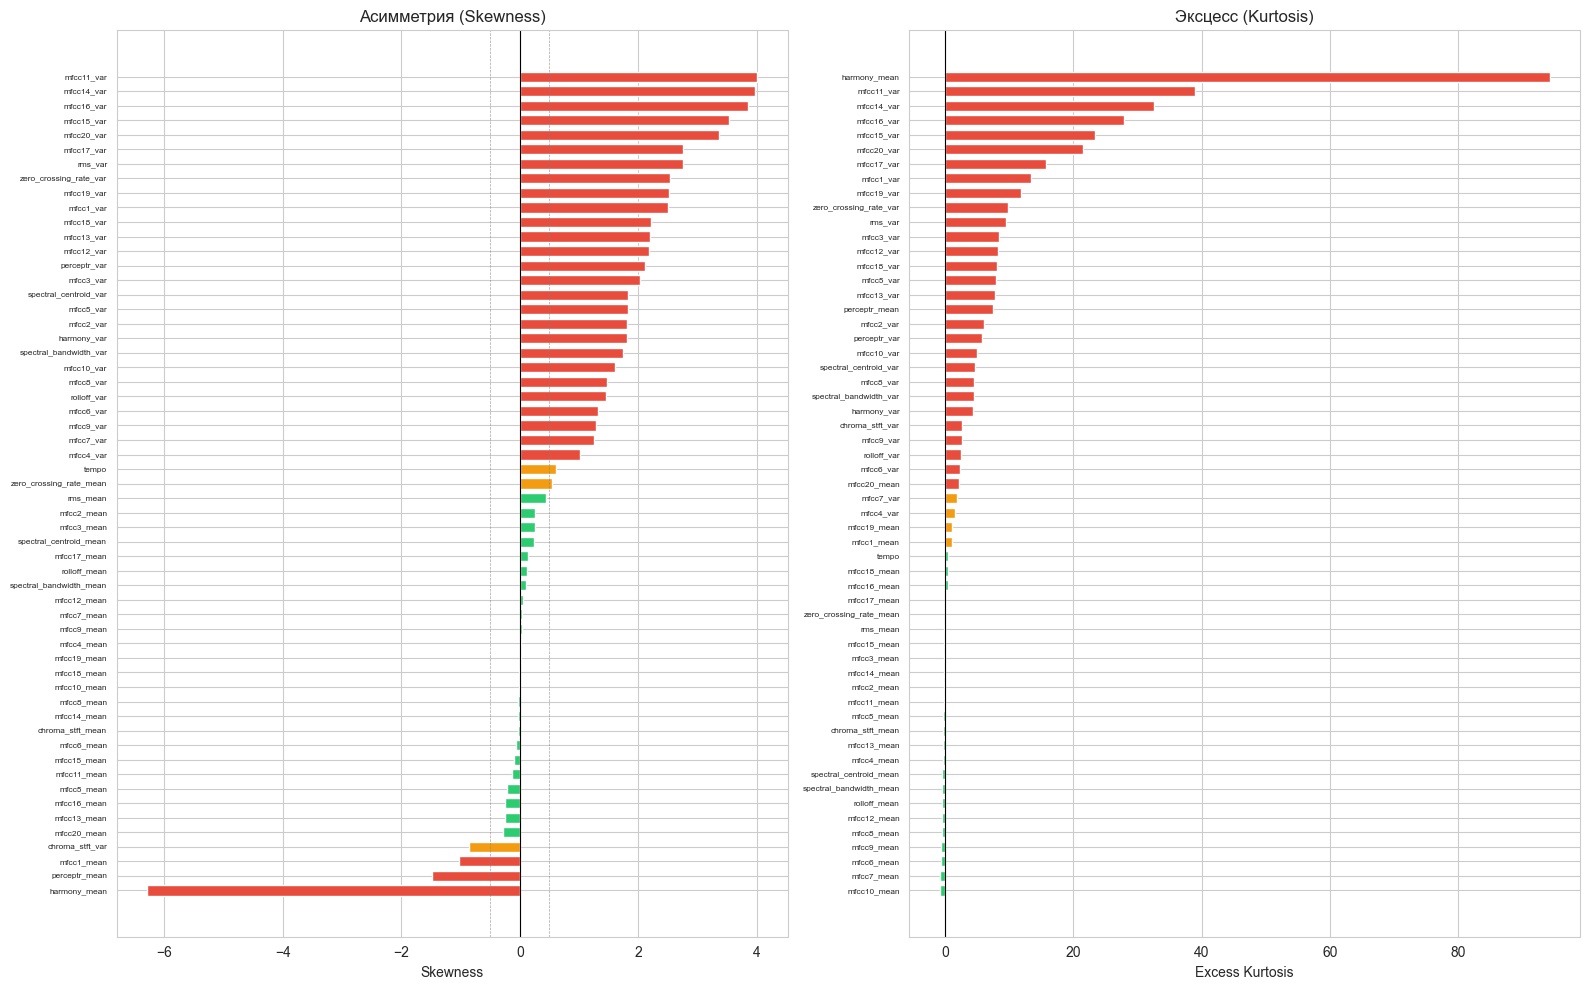

Признаки с сильной асимметрией (|skew| > 1): 30 из 57
Признаки с высоким эксцессом (|kurt| > 2): 29 из 57


In [5]:
skew_vals = data[feature_cols].skew().sort_values()
kurt_vals = data[feature_cols].kurtosis().sort_values()

fig, axes = plt.subplots(1, 2, figsize=(16, 10))

# Асимметрия
colors_skew = [
    "#e74c3c" if abs(v) > 1 else "#f39c12" if abs(v) > 0.5 else "#2ecc71"
    for v in skew_vals
]
axes[0].barh(range(len(skew_vals)), skew_vals.values, color=colors_skew, height=0.7)
axes[0].set_yticks(range(len(skew_vals)))
axes[0].set_yticklabels(skew_vals.index, fontsize=6)
axes[0].axvline(x=0, color="black", linewidth=0.8)
axes[0].axvline(x=-0.5, color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
axes[0].axvline(x=0.5, color="gray", linestyle="--", linewidth=0.5, alpha=0.7)
axes[0].set_title("Асимметрия (Skewness)")
axes[0].set_xlabel("Skewness")

# Эксцесс
colors_kurt = [
    "#e74c3c" if abs(v) > 2 else "#f39c12" if abs(v) > 1 else "#2ecc71"
    for v in kurt_vals
]
axes[1].barh(range(len(kurt_vals)), kurt_vals.values, color=colors_kurt, height=0.7)
axes[1].set_yticks(range(len(kurt_vals)))
axes[1].set_yticklabels(kurt_vals.index, fontsize=6)
axes[1].axvline(x=0, color="black", linewidth=0.8)
axes[1].set_title("Эксцесс (Kurtosis)")
axes[1].set_xlabel("Excess Kurtosis")

plt.tight_layout()
plt.show()

n_skewed = (data[feature_cols].skew().abs() > 1).sum()
n_peaked = (data[feature_cols].kurtosis().abs() > 2).sum()
print(f"Признаки с сильной асимметрией (|skew| > 1): {n_skewed} из {len(feature_cols)}")
print(f"Признаки с высоким эксцессом (|kurt| > 2): {n_peaked} из {len(feature_cols)}")

## Визуализация распределений признаков

Гистограммы с KDE для ключевых признаков из каждой группы. Красная пунктирная линия — среднее, зелёная штрихпунктирная — медиана. Расхождение между ними указывает на асимметрию распределения.

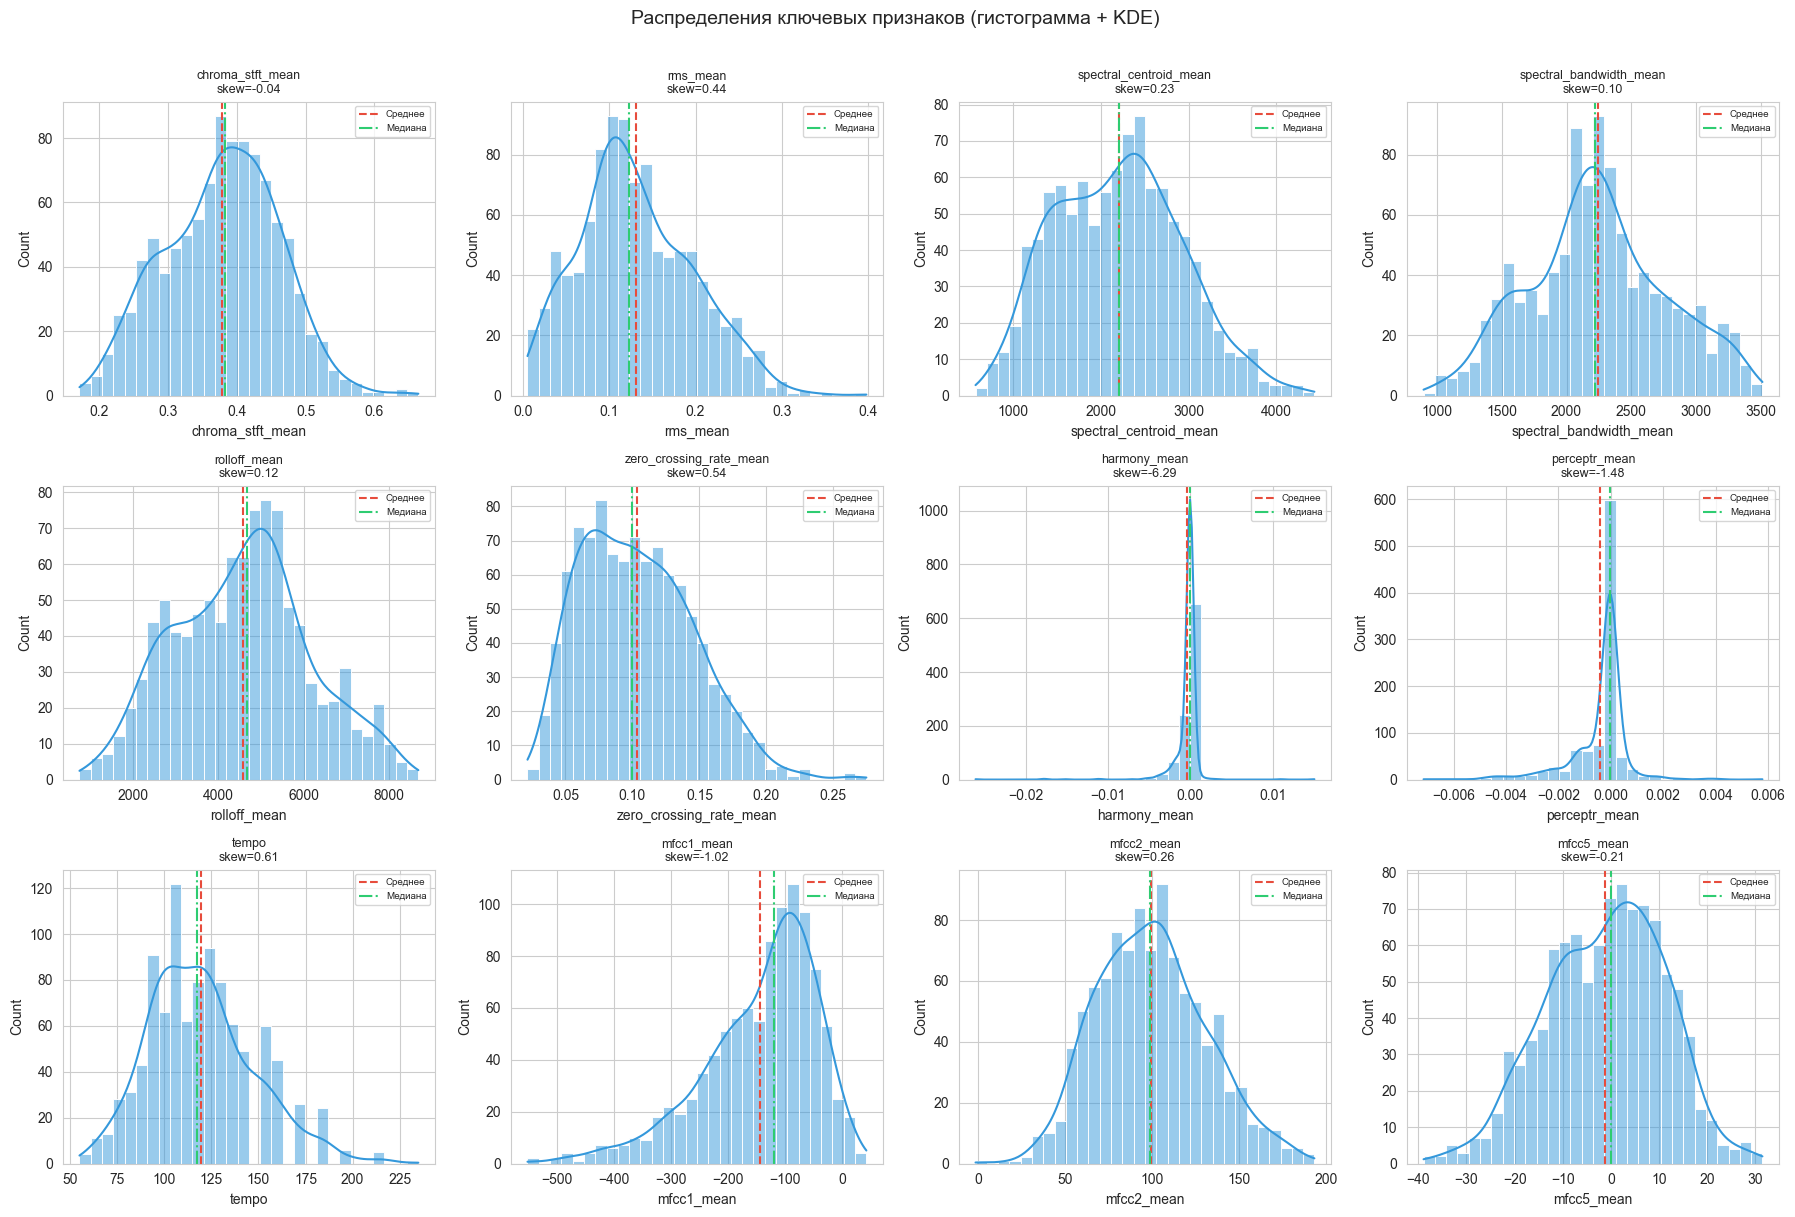

In [6]:
key_features = [
    "chroma_stft_mean", "rms_mean", "spectral_centroid_mean",
    "spectral_bandwidth_mean", "rolloff_mean", "zero_crossing_rate_mean",
    "harmony_mean", "perceptr_mean", "tempo",
    "mfcc1_mean", "mfcc2_mean", "mfcc5_mean",
]

fig, axes = plt.subplots(3, 4, figsize=(18, 12))

for ax, feat in zip(axes.ravel(), key_features):
    sns.histplot(data[feat], kde=True, bins=30, color="#3498db", edgecolor="white", ax=ax)
    ax.axvline(data[feat].mean(), color="#e74c3c", linestyle="--", linewidth=1.5, label="Среднее")
    ax.axvline(data[feat].median(), color="#2ecc71", linestyle="-.", linewidth=1.5, label="Медиана")
    sk = data[feat].skew()
    ax.set_title(f"{feat}\nskew={sk:.2f}", fontsize=9)
    ax.legend(fontsize=7)

plt.suptitle("Распределения ключевых признаков (гистограмма + KDE)", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## Обнаружение выбросов (метод IQR)

Выбросом считается значение, выходящее за пределы **[Q1 − 1.5·IQR, Q3 + 1.5·IQR]**. Подсчитаем количество выбросов для каждого признака и визуализируем наиболее «проблемные».

Топ-15 признаков по количеству выбросов:
harmony_mean              239
perceptr_mean             154
rms_var                    92
zero_crossing_rate_var     87
perceptr_var               61
mfcc18_var                 57
spectral_centroid_var      54
mfcc20_var                 52
harmony_var                50
mfcc19_var                 49
mfcc17_var                 46
mfcc2_var                  45
mfcc15_var                 44
mfcc13_var                 42
mfcc16_var                 41

Всего признаков с выбросами: 53 из 57


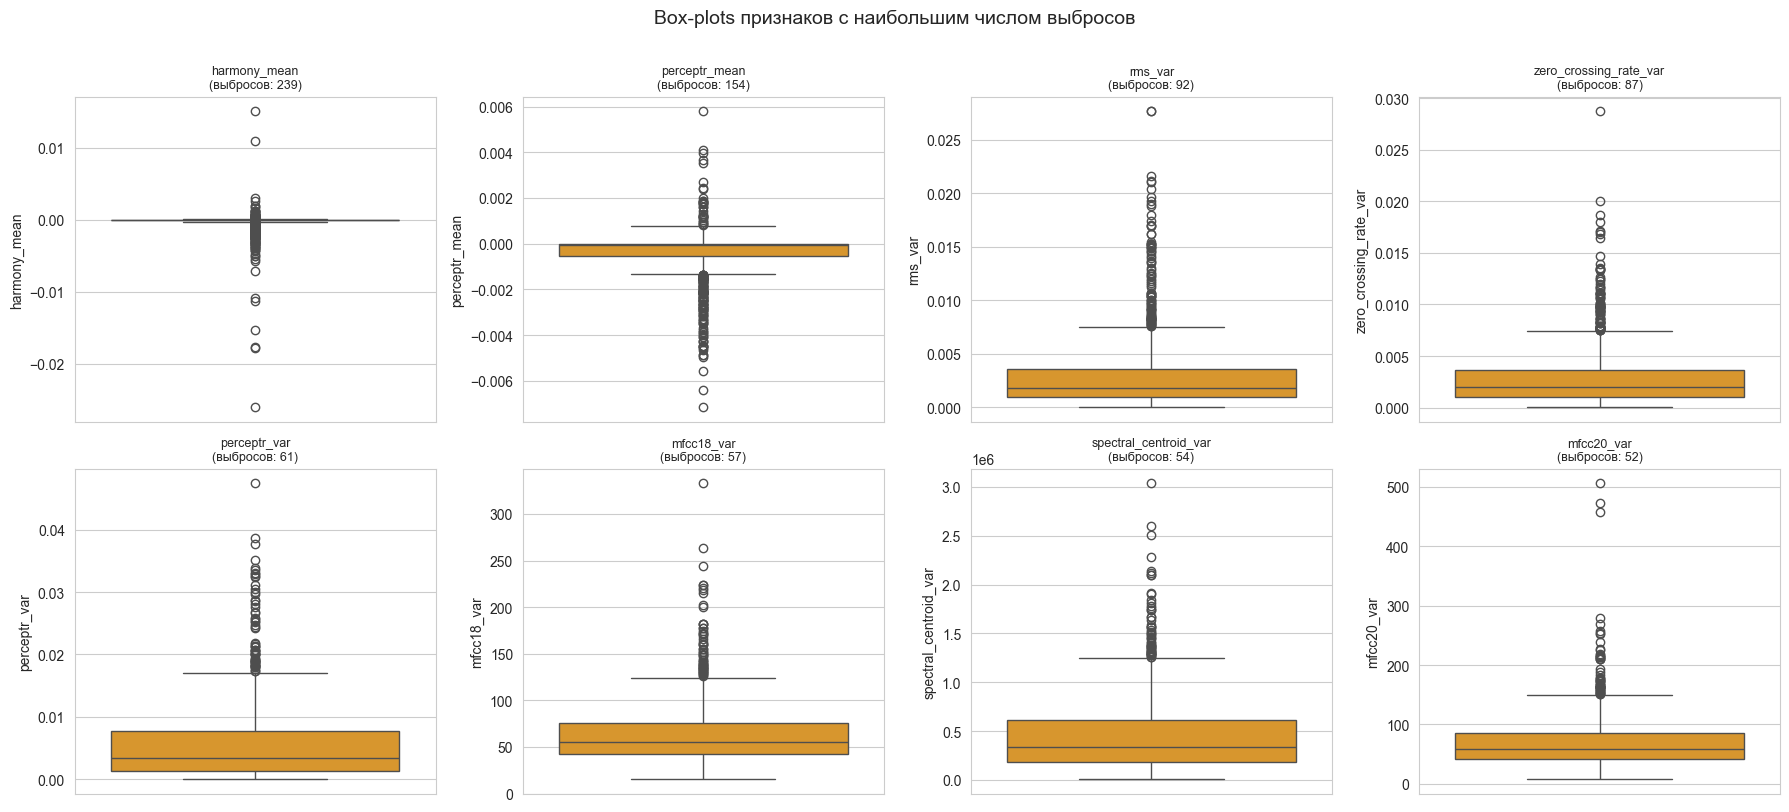

In [7]:
Q1 = data[feature_cols].quantile(0.25)
Q3 = data[feature_cols].quantile(0.75)
IQR = Q3 - Q1

lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR
outlier_counts = ((data[feature_cols] < lower) | (data[feature_cols] > upper)).sum().sort_values(ascending=False)

print("Топ-15 признаков по количеству выбросов:")
print(outlier_counts.head(15).to_string())
print(f"\nВсего признаков с выбросами: {(outlier_counts > 0).sum()} из {len(feature_cols)}")

# Box plots для топ-8
top_outlier_features = outlier_counts.head(8).index.tolist()

fig, axes = plt.subplots(2, 4, figsize=(18, 8))
for ax, feat in zip(axes.ravel(), top_outlier_features):
    sns.boxplot(y=data[feat], color="#f39c12", ax=ax)
    ax.set_title(f"{feat}\n(выбросов: {outlier_counts[feat]})", fontsize=9)

plt.suptitle("Box-plots признаков с наибольшим числом выбросов", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## Матрица корреляции

Рассчитаем корреляцию Пирсона для всех числовых признаков. Поскольку 57 признаков дают большую матрицу, дополнительно построим фокусированную карту для спектральных и энергетических признаков.

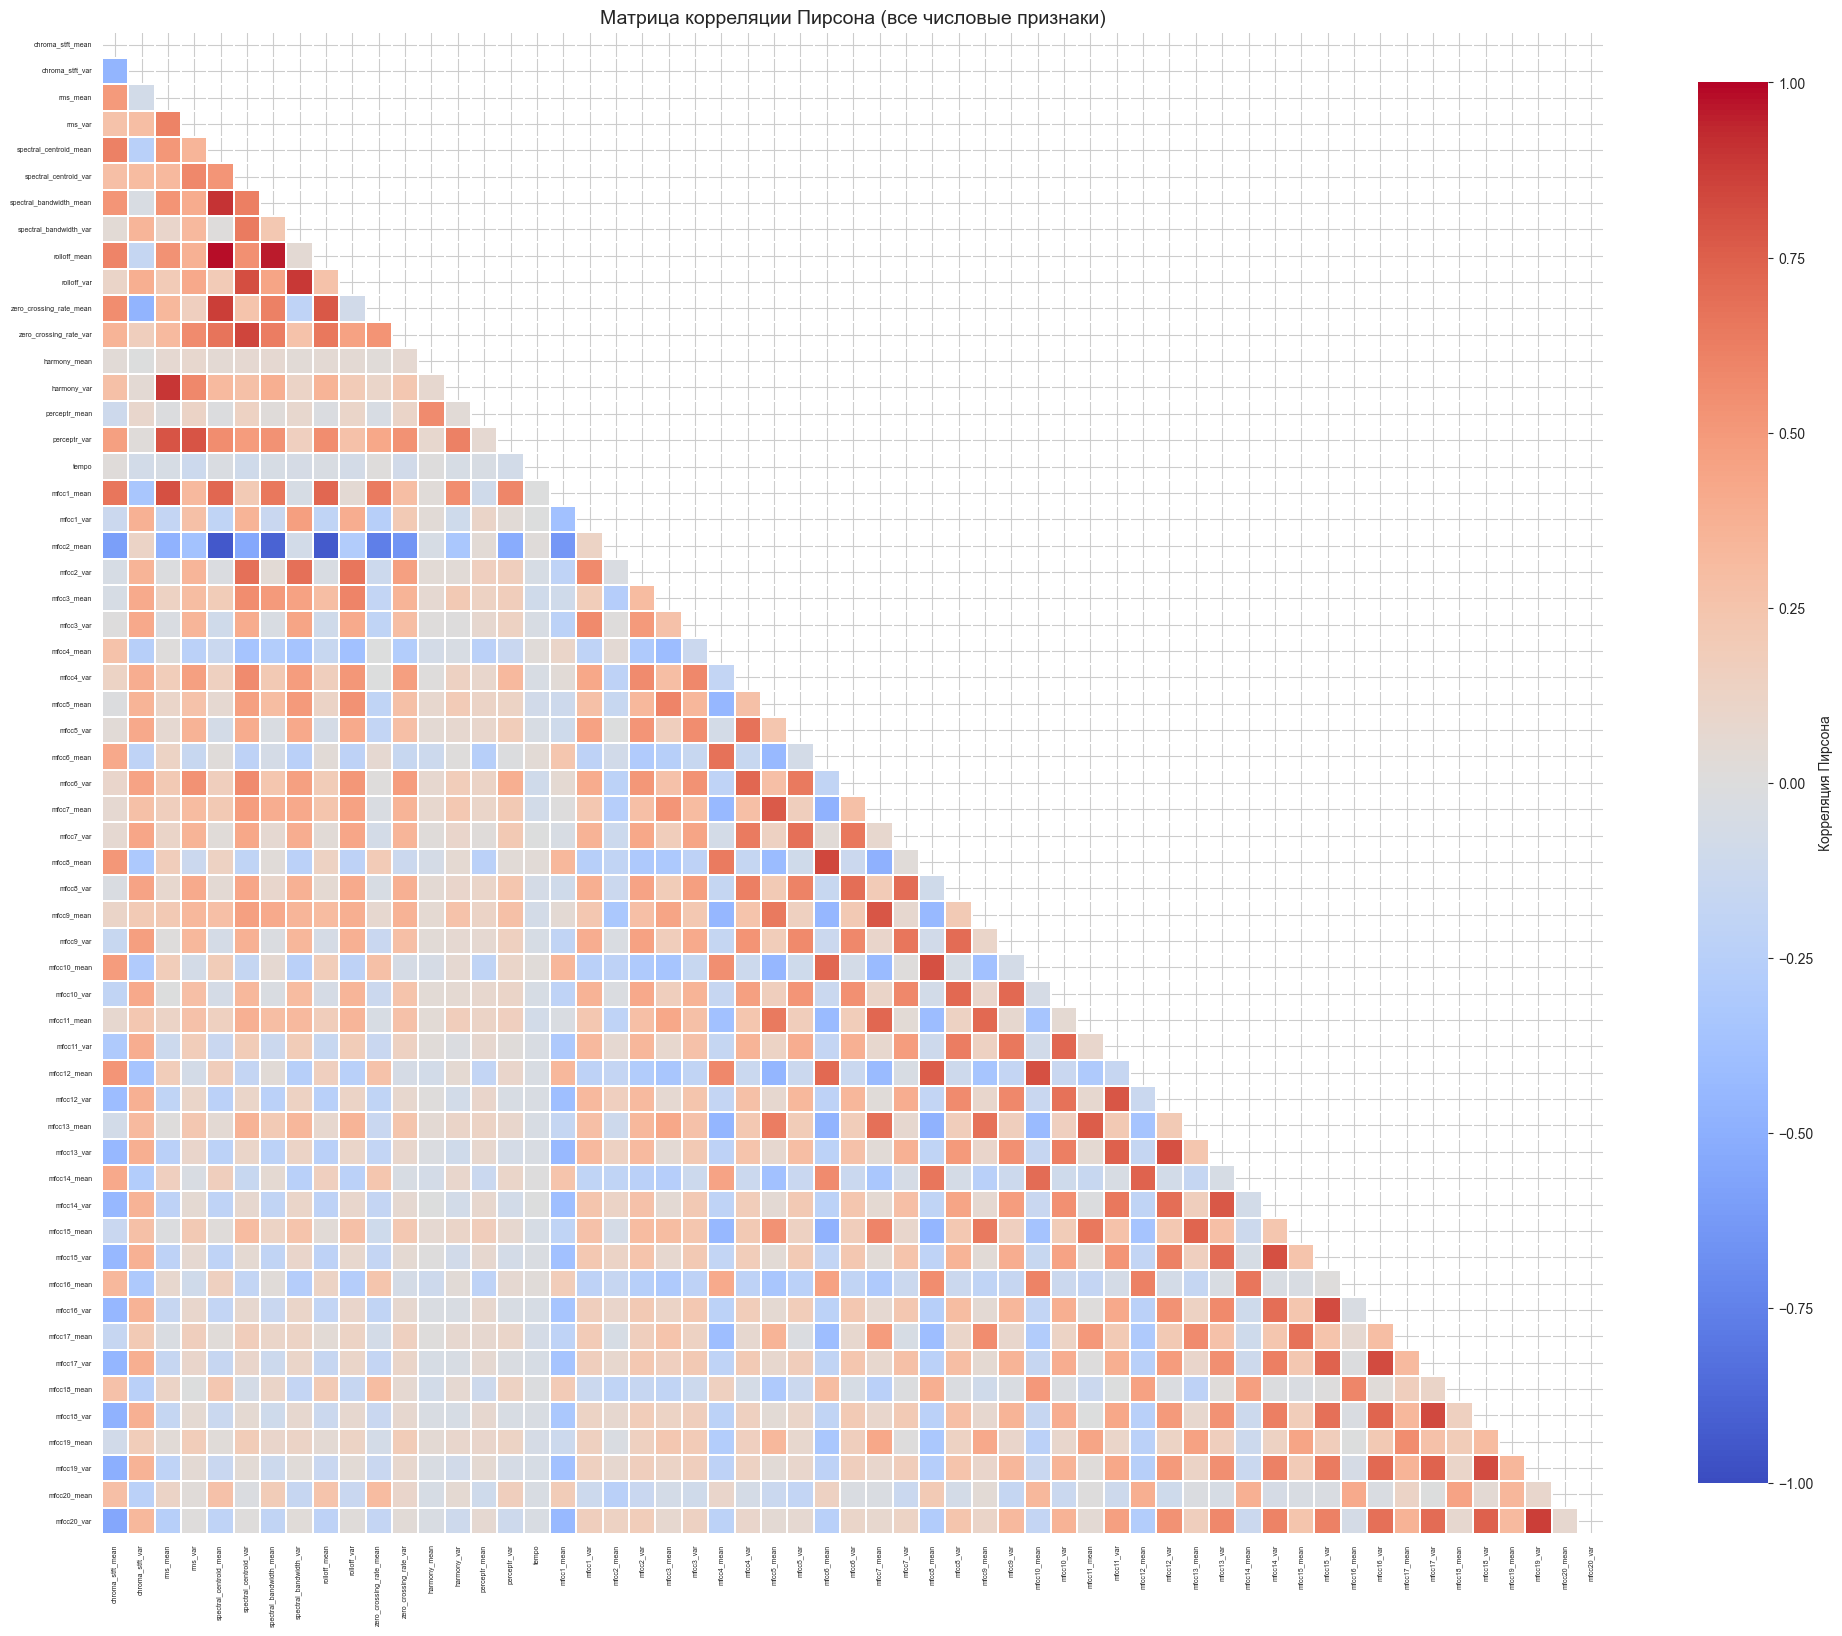

In [8]:
corr_matrix = data[feature_cols].corr(method="pearson")

plt.figure(figsize=(20, 18))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(
    corr_matrix, mask=mask, cmap="coolwarm", center=0,
    vmin=-1, vmax=1, linewidths=0.1, square=True,
    cbar_kws={"shrink": 0.8, "label": "Корреляция Пирсона"},
    xticklabels=True, yticklabels=True,
)
plt.xticks(fontsize=5, rotation=90)
plt.yticks(fontsize=5)
plt.title("Матрица корреляции Пирсона (все числовые признаки)", fontsize=14)
plt.tight_layout()
plt.show()

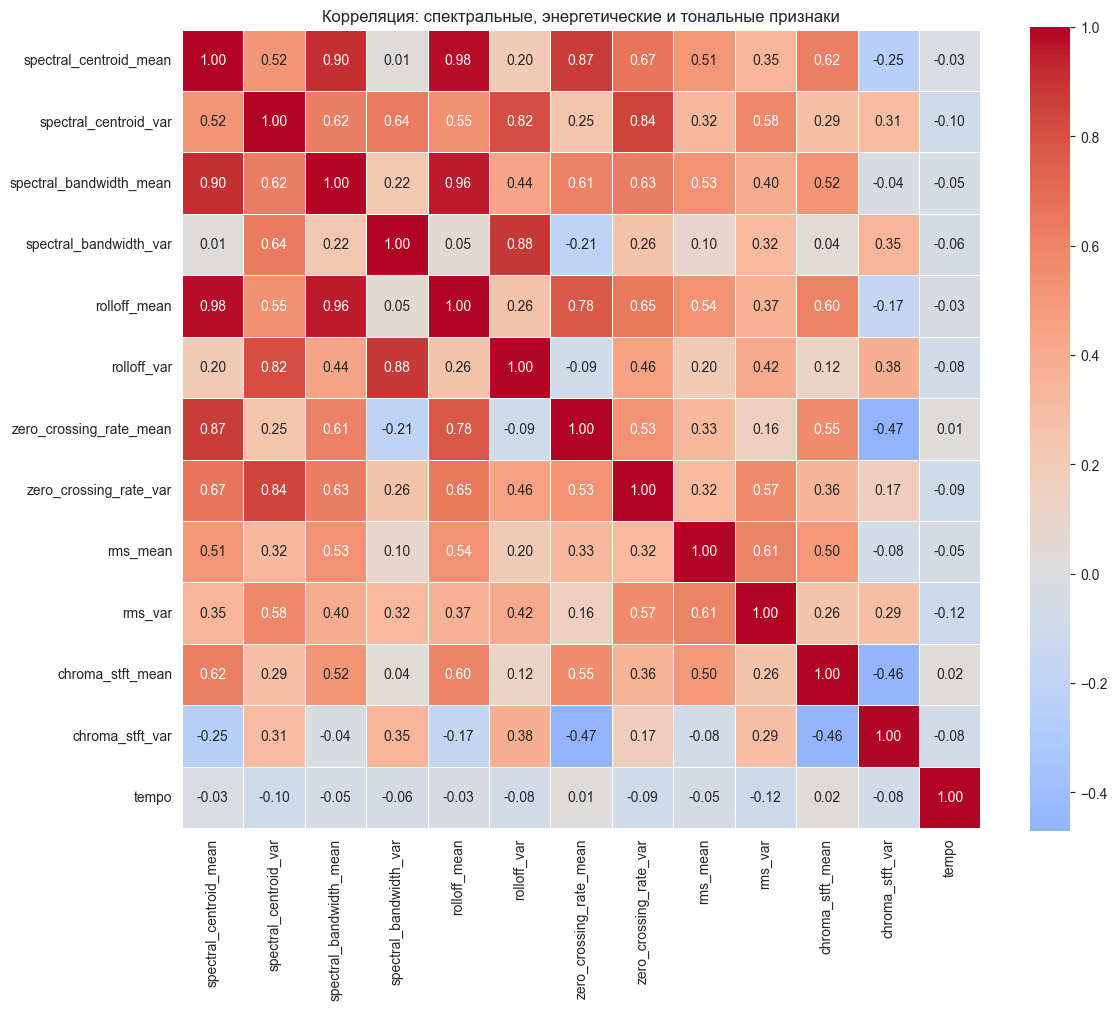

In [9]:
focus_cols = (
    feature_groups["Спектральные"]
    + feature_groups["Энергия (RMS)"]
    + feature_groups["Chroma"]
    + ["tempo"]
)
corr_focus = data[focus_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(
    corr_focus, annot=True, fmt=".2f", cmap="coolwarm", center=0,
    linewidths=0.5, square=True,
)
plt.title("Корреляция: спектральные, энергетические и тональные признаки", fontsize=12)
plt.tight_layout()
plt.show()

In [10]:
# Топ пар по корреляции
corr_pairs = corr_matrix.unstack()
corr_pairs = corr_pairs[
    corr_pairs.index.get_level_values(0) < corr_pairs.index.get_level_values(1)
]
corr_pairs = corr_pairs.reindex(corr_pairs.abs().sort_values(ascending=False).index)

print("Топ-10 пар с наибольшей корреляцией (по модулю):")
for (f1, f2), val in corr_pairs.head(10).items():
    print(f"  {f1:35s} <-> {f2:35s}  r = {val:+.4f}")

print(f"\nТоп-10 пар с наименьшей корреляцией:")
for (f1, f2), val in corr_pairs.tail(10).items():
    print(f"  {f1:35s} <-> {f2:35s}  r = {val:+.4f}")

Топ-10 пар с наибольшей корреляцией (по модулю):
  rolloff_mean                        <-> spectral_centroid_mean               r = +0.9796
  rolloff_mean                        <-> spectral_bandwidth_mean              r = +0.9562
  mfcc2_mean                          <-> spectral_centroid_mean               r = -0.9402
  mfcc2_mean                          <-> rolloff_mean                         r = -0.9343
  spectral_bandwidth_mean             <-> spectral_centroid_mean               r = +0.9044
  mfcc2_mean                          <-> spectral_bandwidth_mean              r = -0.8967
  harmony_var                         <-> rms_mean                             r = +0.8939
  rolloff_var                         <-> spectral_bandwidth_var               r = +0.8849
  spectral_centroid_mean              <-> zero_crossing_rate_mean              r = +0.8747
  mfcc19_var                          <-> mfcc20_var                           r = +0.8687

Топ-10 пар с наименьшей корреляцией:
  m

## Сравнение корреляций Пирсона и Спирмена

Корреляция Пирсона измеряет **линейную** связь и чувствительна к выбросам. Корреляция Спирмена — **ранговая**, устойчива к выбросам и не требует нормальности. Сравним оба метода, чтобы оценить, насколько связи между признаками отклоняются от линейных.

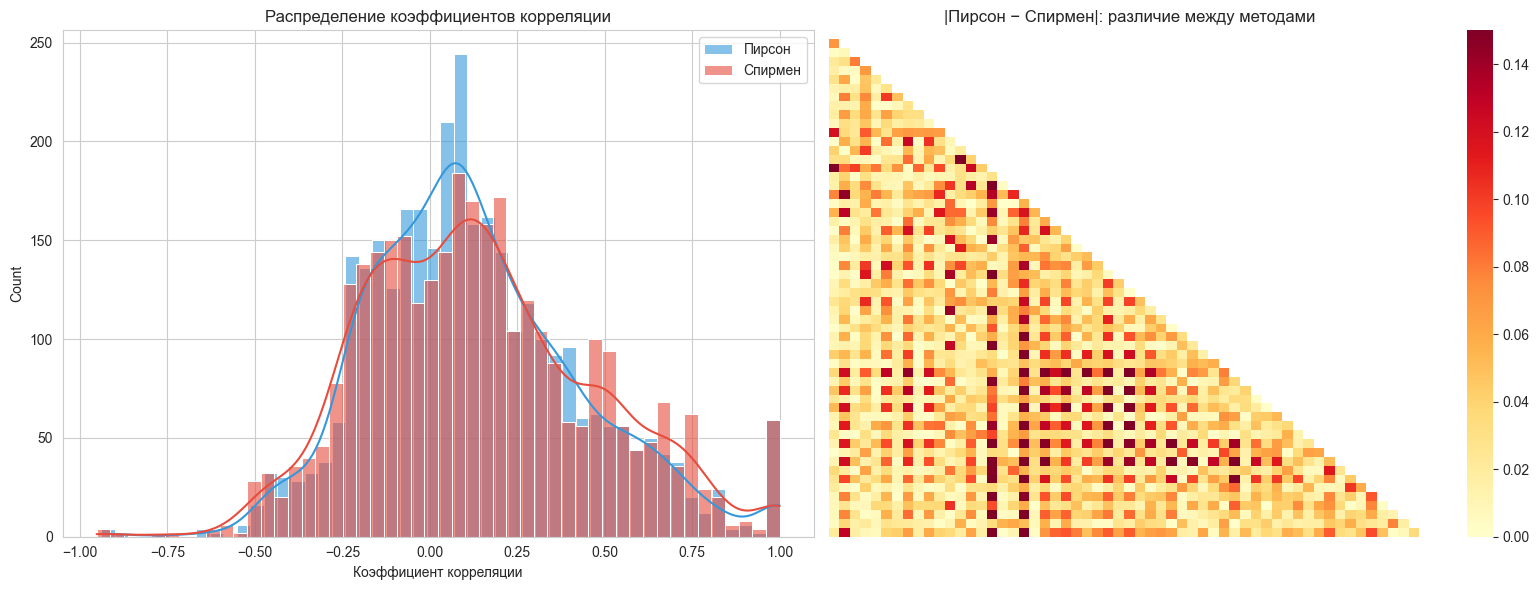

Средняя разница |Pearson − Spearman|: 0.0434
Максимальная разница: 0.2403


In [11]:
corr_pearson = data[feature_cols].corr(method="pearson")
corr_spearman = data[feature_cols].corr(method="spearman")

diff = (corr_pearson - corr_spearman).abs()

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.histplot(corr_pearson.values.flatten(), bins=50, color="#3498db", label="Пирсон", alpha=0.6, kde=True, ax=axes[0])
sns.histplot(corr_spearman.values.flatten(), bins=50, color="#e74c3c", label="Спирмен", alpha=0.6, kde=True, ax=axes[0])
axes[0].set_title("Распределение коэффициентов корреляции")
axes[0].set_xlabel("Коэффициент корреляции")
axes[0].legend()

mask = np.triu(np.ones_like(diff, dtype=bool))
sns.heatmap(diff, mask=mask, cmap="YlOrRd", vmin=0, vmax=0.15,
            xticklabels=False, yticklabels=False, ax=axes[1])
axes[1].set_title("|Пирсон − Спирмен|: различие между методами")

plt.tight_layout()
plt.show()

lower_tri = diff.values[np.tril_indices_from(diff.values, -1)]
print(f"Средняя разница |Pearson − Spearman|: {lower_tri.mean():.4f}")
print(f"Максимальная разница: {lower_tri.max():.4f}")

## Взаимосвязь признаков с целевой переменной (жанр)

Целевая переменная `label` — **категориальная** (10 жанров). Для анализа связи числовых признаков с категориальным выходом используем:

1. **Групповые статистики** — среднее значение признаков по жанрам (тепловая карта)
2. **Критерий Краскела–Уоллиса** — непараметрический аналог ANOVA: проверяет, значимо ли различаются распределения признака между жанрами
3. **Violin-plots** — визуализация различий распределений между жанрами для наиболее дискриминативных признаков

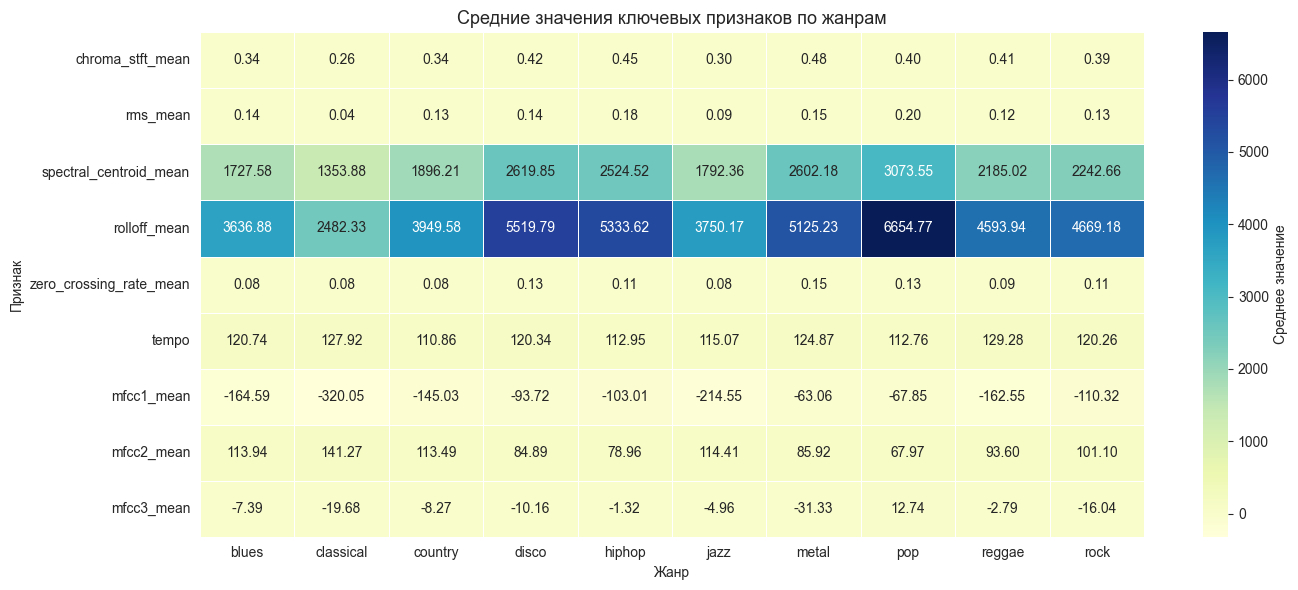

In [12]:
key_feats = [
    "chroma_stft_mean", "rms_mean", "spectral_centroid_mean",
    "rolloff_mean", "zero_crossing_rate_mean", "tempo",
    "mfcc1_mean", "mfcc2_mean", "mfcc3_mean",
]

genre_means = data.groupby("label")[key_feats].mean()

plt.figure(figsize=(14, 6))
sns.heatmap(
    genre_means.T, annot=True, fmt=".2f", cmap="YlGnBu",
    linewidths=0.5, cbar_kws={"label": "Среднее значение"},
)
plt.title("Средние значения ключевых признаков по жанрам", fontsize=13)
plt.xlabel("Жанр")
plt.ylabel("Признак")
plt.tight_layout()
plt.show()

In [13]:
genres = data["label"].unique()
kw_results = []

for feat in feature_cols:
    genre_groups = [data.loc[data["label"] == g, feat].values for g in genres]
    stat, p_value = stats.kruskal(*genre_groups)
    kw_results.append({"Признак": feat, "H-статистика": round(stat, 2), "p-value": round(p_value, 6)})

kw_df = pd.DataFrame(kw_results).sort_values("H-статистика", ascending=False).reset_index(drop=True)
kw_df["Значимо (p < 0.05)"] = kw_df["p-value"] < 0.05

significant = kw_df["Значимо (p < 0.05)"].sum()
print(f"Признаки, значимо различающиеся между жанрами: {significant} из {len(feature_cols)}")
print(f"\nТоп-15 признаков по силе различий (H-статистика):")
print(kw_df.head(15).to_string(index=False))

Признаки, значимо различающиеся между жанрами: 57 из 57

Топ-15 признаков по силе различий (H-статистика):
                Признак  H-статистика  p-value  Значимо (p < 0.05)
       chroma_stft_mean      617.8700   0.0000                True
           perceptr_var      567.8300   0.0000                True
  spectral_centroid_var      542.9700   0.0000                True
spectral_bandwidth_mean      493.0400   0.0000                True
           rolloff_mean      487.2000   0.0000                True
 spectral_centroid_mean      481.8900   0.0000                True
             mfcc1_mean      477.8100   0.0000                True
 zero_crossing_rate_var      463.1700   0.0000                True
                rms_var      441.8100   0.0000                True
            rolloff_var      434.3400   0.0000                True
             mfcc2_mean      425.9700   0.0000                True
             mfcc4_mean      423.4100   0.0000                True
              mfcc6_va

C:\Users\ichap\AppData\Local\Temp\ipykernel_360088\2988357325.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="label", y=feat, palette="Set3", ax=ax, inner="quartile")
C:\Users\ichap\AppData\Local\Temp\ipykernel_360088\2988357325.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="label", y=feat, palette="Set3", ax=ax, inner="quartile")
C:\Users\ichap\AppData\Local\Temp\ipykernel_360088\2988357325.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=data, x="label", y=feat, palette="Set3", ax=ax, i

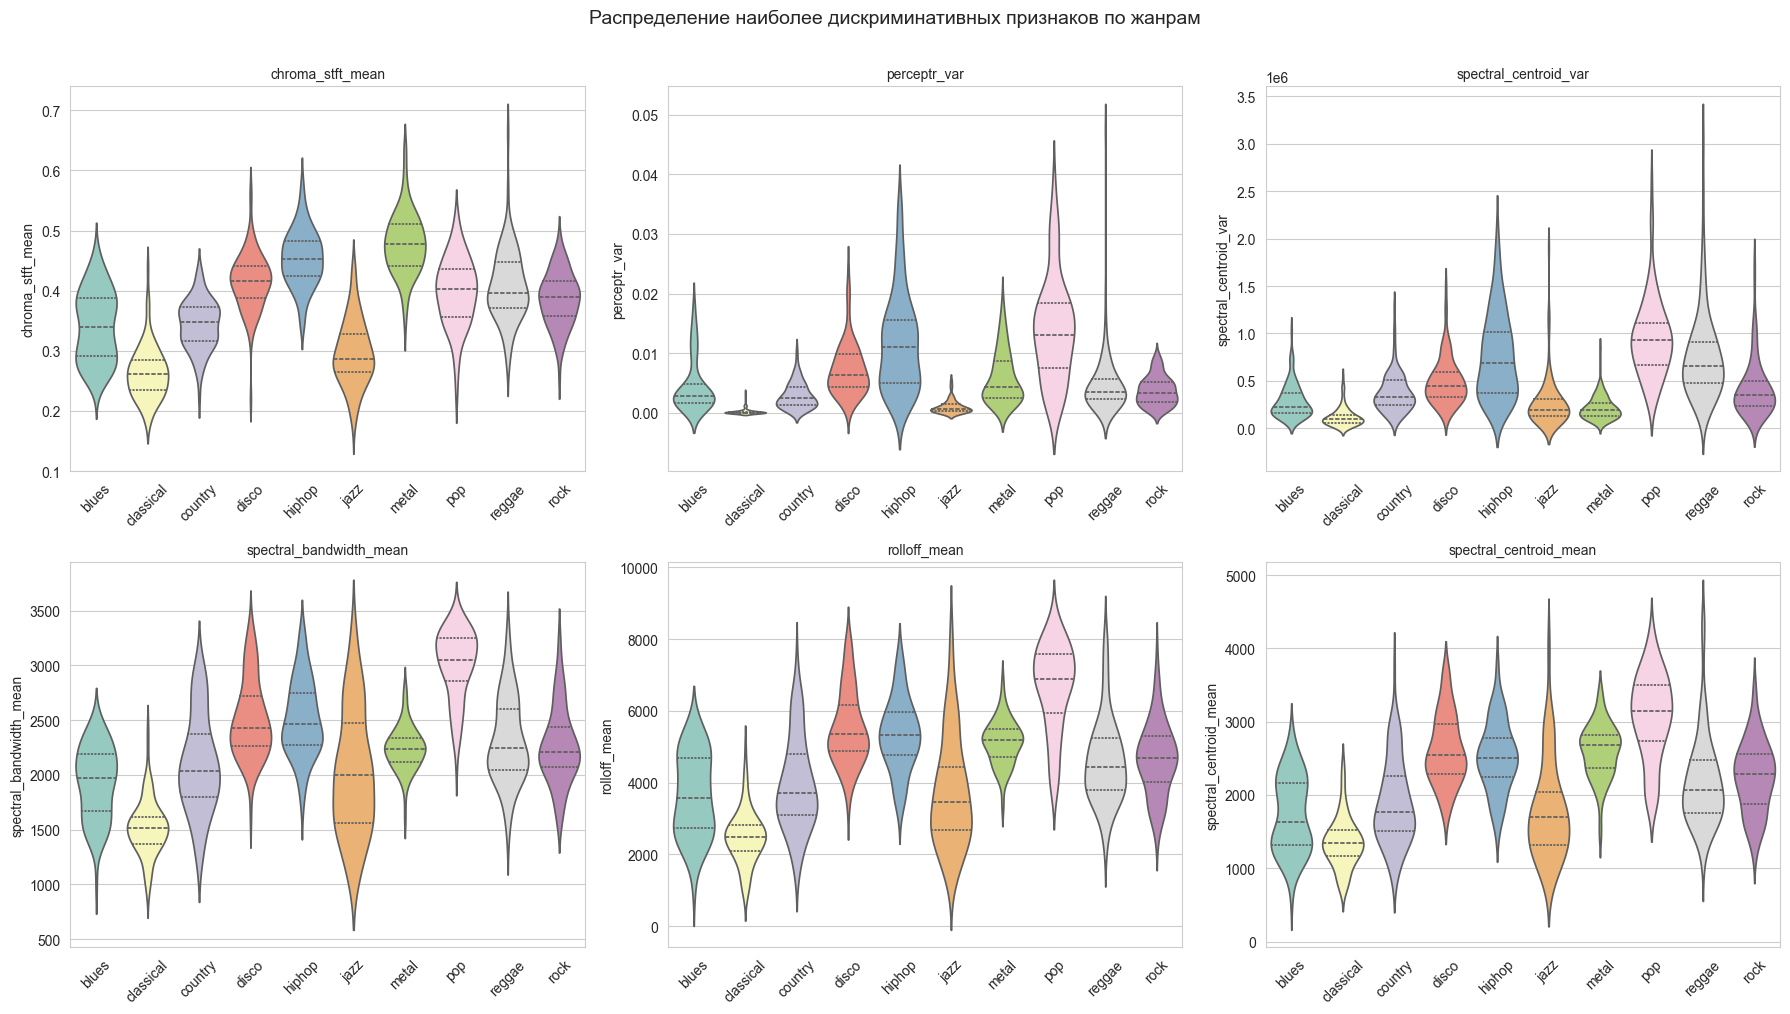

In [14]:
top_discriminative = kw_df.head(6)["Признак"].tolist()

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

for ax, feat in zip(axes.ravel(), top_discriminative):
    sns.violinplot(data=data, x="label", y=feat, palette="Set3", ax=ax, inner="quartile")
    ax.set_title(feat, fontsize=10)
    ax.set_xlabel("")
    ax.tick_params(axis="x", rotation=45)

plt.suptitle("Распределение наиболее дискриминативных признаков по жанрам", fontsize=14, y=1.01)
plt.tight_layout()
plt.show()

## Выводы

1. **Структура данных:** датасет GTZAN содержит 1000 записей (10 жанров по 100), 57 числовых аудиопризнаков. Пропущенные значения отсутствуют, классы идеально сбалансированы.

2. **Масштабы признаков:** признаки имеют существенно различные масштабы — от долей единицы (`chroma_stft_mean`) до сотен тысяч (`rolloff_var`), что указывает на необходимость масштабирования при обучении моделей.

3. **Форма распределений:** значительная часть признаков имеет выраженную асимметрию и положительный эксцесс, что свидетельствует о наличии тяжёлых хвостов. Распределения большинства признаков не являются нормальными.

4. **Выбросы:** методом IQR обнаружены выбросы в большинстве признаков. При подготовке данных для моделей стоит рассмотреть робастное масштабирование или обработку выбросов.

5. **Корреляции:** выявлены сильные корреляции между спектральными признаками (`spectral_centroid`, `rolloff`, `spectral_bandwidth`), что логично — это связанные частотные характеристики. MFCC-коэффициенты слабо коррелируют друг с другом, что делает их информативными для классификации.

6. **Различия по жанрам:** критерий Краскела–Уоллиса показал, что подавляющее большинство признаков статистически значимо различаются между жанрами (p < 0.05). Наиболее дискриминативные признаки будут полезны при построении классификатора жанров.